In [1]:
import time

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

# Test data

In [2]:
h = 1  # discretization step in s
g = 0.1  # gravity in m/s^2
m = 10.0  # mass in kg
F_max = 10.0  # maximum thrust in Newton
p_target = np.array([0, 0, 0])  # target position in m
alpha = np.pi / 8  # glide angle in rad
gamma = 1.0  # fuel consumption coefficient
K = 35  # number of discretization steps

# Formulate the optimization problem

In [3]:
def optimize_fuel(
    p_target: np.ndarray,
    g: float,
    m: float,
    K: int,
    h: float,
    F_max: float,
    alpha: float,
    gamma: float,
) -> cp.Problem:
    """

    Minimize fuel consumption for a rocket to land on a target

    :param p_target: landing target in m
    :param g: gravitational acceleration in m/s^2
    :param m: mass in kg
    :param K: Number of discretization steps
    :param h: discretization step in s
    :param F_max: maximum thrust of engine in kg*m/s^2 (Newton)
    :param alpha: Glide path angle in radian
    :param gamma: converts fuel consumption to liters of fuel consumption
    :return: parametrized problem
    """

    P_min = p_target[2]

    # Parameters are symbolic constants, i.e., we can set the values later
    p0 = cp.Parameter(3)
    v0 = cp.Parameter(3)

    # Variables
    V = cp.Variable((K + 1, 3))  # velocity
    P = cp.Variable((K + 1, 3))  # position
    F = cp.Variable((K, 3))  # thrust

    # Constraints
    # Match initial position and initial velocity
    constraints = [
        V[0] == v0,
        P[0] == p0,
    ]

    # Keep height above P_min
    constraints += [P[:, 2] >= P_min]

    # Match final position and 0 velocity
    constraints += [
        V[K] == [0, 0, 0],
        P[K] == p_target,
    ]

    # Physics dynamics for velocity
    constraints += [V[1:, :2] == V[:-1, :2] + h * (F[:, :2] / m)]
    constraints += [V[1:, 2] == V[:-1, 2] + h * (F[:, 2] / m - g)]

    # Physics dynamics for position
    constraints += [P[1:] == P[:-1] + (h / 2) * (V[:-1] + V[1:])]

    # Glide path constraint
    constraints += [P[:, 2] >= np.tan(alpha) * cp.norm(P[:, :2], axis=1)]

    # Maximum thrust constraint
    constraints += [cp.norm(F, 2, axis=1) <= F_max]

    fuel_consumption = gamma * cp.sum(cp.norm(F, axis=1))

    problem = cp.Problem(cp.Minimize(fuel_consumption), constraints)
    return problem, p0, v0

# Solve the problem many times

We solve the problem many times and observe a large speedup after the first solve when using a parametrized problem.
This is because the canonicalization map is only computed once and cached for subsequent solves.

In [4]:
parametrized_problem, p0, v0 = optimize_fuel(p_target, g, m, K, h, F_max, alpha, gamma)

times = []
for i in range(100):
    start = time.time()
    p0.value = np.array([50, 50, 100]) + np.random.random(3)
    v0.value = np.array([-10, 0, -10]) + np.random.random(3)
    parametrized_problem.solve()
    times.append(time.time() - start)

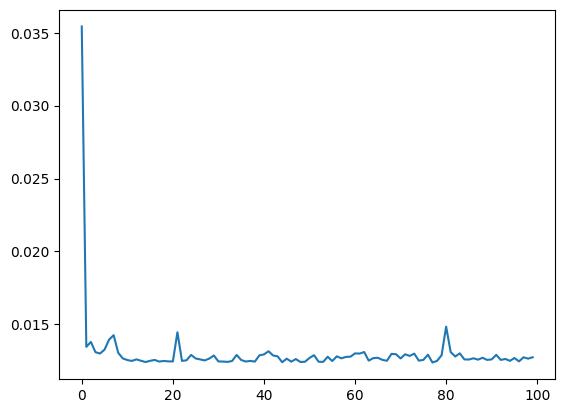

In [5]:
plt.plot(times)